In [1]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

--2022-10-16 20:52:06--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “SimHei.ttf.8”

SimHei.ttf.8        100%[===================>]   9.58M  11.8MB/s    用时 0.8s    

2022-10-16 20:52:07 (11.8 MB/s) - 已保存 “SimHei.ttf.8” [10050868/10050868])



In [53]:
import matplotlib.pylot as plt

ModuleNotFoundError: No module named 'matplotlib.pylot'

In [54]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [5]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [6]:
# 数据集文件夹路径
# ../返回上一个文件夹
# ./当前文件夹
dataset_dir = 'dataset_split'

In [7]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 dataset_split/train
测试集路径 dataset_split/val


In [8]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [9]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 4603
类别个数 23
各类别名称 ['MP3', 't恤衫', '体育用品', '外套', '家具', '平板电脑', '快餐', '手机', '文具', '无线耳机', '有线耳机', '毛衣', '生鲜', '短裙', '短裤', '笔记本电脑', '衬衣', '酱料', '长裙', '长裤', '零食', '鞋子', '饮品']


In [10]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 1144
类别个数 23
各类别名称 ['MP3', 't恤衫', '体育用品', '外套', '家具', '平板电脑', '快餐', '手机', '文具', '无线耳机', '有线耳机', '毛衣', '生鲜', '短裙', '短裤', '笔记本电脑', '衬衣', '酱料', '长裙', '长裤', '零食', '鞋子', '饮品']


In [11]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [12]:
class_names

['MP3',
 't恤衫',
 '体育用品',
 '外套',
 '家具',
 '平板电脑',
 '快餐',
 '手机',
 '文具',
 '无线耳机',
 '有线耳机',
 '毛衣',
 '生鲜',
 '短裙',
 '短裤',
 '笔记本电脑',
 '衬衣',
 '酱料',
 '长裙',
 '长裤',
 '零食',
 '鞋子',
 '饮品']

In [13]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'MP3': 0,
 't恤衫': 1,
 '体育用品': 2,
 '外套': 3,
 '家具': 4,
 '平板电脑': 5,
 '快餐': 6,
 '手机': 7,
 '文具': 8,
 '无线耳机': 9,
 '有线耳机': 10,
 '毛衣': 11,
 '生鲜': 12,
 '短裙': 13,
 '短裤': 14,
 '笔记本电脑': 15,
 '衬衣': 16,
 '酱料': 17,
 '长裙': 18,
 '长裤': 19,
 '零食': 20,
 '鞋子': 21,
 '饮品': 22}

In [14]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [15]:
idx_to_labels

{0: 'MP3',
 1: 't恤衫',
 2: '体育用品',
 3: '外套',
 4: '家具',
 5: '平板电脑',
 6: '快餐',
 7: '手机',
 8: '文具',
 9: '无线耳机',
 10: '有线耳机',
 11: '毛衣',
 12: '生鲜',
 13: '短裙',
 14: '短裤',
 15: '笔记本电脑',
 16: '衬衣',
 17: '酱料',
 18: '长裙',
 19: '长裤',
 20: '零食',
 21: '鞋子',
 22: '饮品'}

In [16]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

In [17]:
from torch.utils.data import DataLoader

In [18]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [19]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [20]:
images.shape

torch.Size([32, 3, 224, 224])

In [21]:
labels

tensor([ 8,  5, 14, 19, 19,  4,  9, 21, 14,  7,  5, 19, 17,  8,  2,  3, 13, 16,
         2,  4,  8,  4,  8, 13, 11, 22,  6,  2,  8, 22, 18,  6])

In [22]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [23]:
images[5].shape

(3, 224, 224)

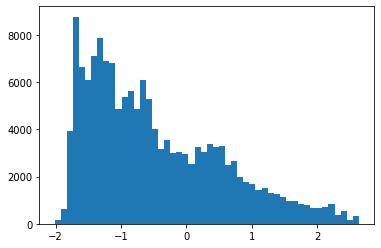

In [24]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:14')

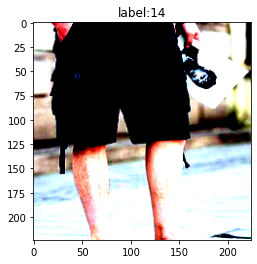

In [25]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [26]:
label = labels[idx].item()

In [27]:
label

14

In [28]:
pred_classname = idx_to_labels[label]

In [29]:
pred_classname

'短裤'

In [31]:
from torchvision import models
import torch.optim as optim

In [32]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
model.fc

Linear(in_features=512, out_features=23, bias=True)

In [34]:
# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())

In [35]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 20

In [36]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [37]:
# 输入模型，执行前向预测
outputs = model(images)

In [38]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 23])

In [39]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [40]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [41]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

In [42]:
preds

tensor([ 0, 10, 19, 10, 19, 19, 10,  8,  0, 10,  0, 18, 22, 19, 17,  0, 14, 17,
        19,  1, 10, 18, 19, 17,  0, 17, 19, 20, 19, 16, 20, 19],
       device='cuda:0')

In [43]:
labels

tensor([ 3,  1,  3,  4, 16,  5,  4,  2,  7, 19,  2, 17, 17, 14,  8, 13,  5,  4,
        10,  4,  6,  0, 13,  2,  2, 20, 11,  4,  4,  3, 10, 18],
       device='cuda:0')

In [44]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获得一个 batch 的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [03:37<00:00, 10.85s/it]


In [45]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 36/36 [00:07<00:00,  4.95it/s]

测试集上的准确率为 84.353 %


In [46]:
torch.save(model, 'checkpoints/dataset_pytorch_20220814.pth')